Prepare your environment:

In [32]:
# for acquiring:
import numpy as np
import pandas as pd
# for plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# for analysis:
import scipy.stats as stats
# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#for specific acq and prep:
from acquire_zillow import *
from prepare_zillow import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans


In [2]:
# df = get_zillow()
df = pd.read_csv('zillow.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
# insert a peek at data here if you want

In [4]:
# utilize prep function
df = prep_zillow(df)

In [121]:
get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []

In [6]:
# reset messy indeces:

df.reset_index(inplace=True, drop=True)

In [7]:
## scale numeric values in df:

scaler = MinMaxScaler()
num_vars = list(df.select_dtypes('number').columns)
num_vars = num_vars[1:-1]
# select more nuanced list of variables to scale as we don't want to scale every numberic variable
scale_vars = ['calculatedfinishedsquarefeet','lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
def scale_vars(df): 
    scaler = MinMaxScaler()
    df[scale_vars] = scaler.fit_transform(df[scale_vars])
scale_vars(df)


In [8]:
# add manually calculated bed and bath column to make up for redundancy and 
# error in calculatedbedandbath columns
df['bed_and_bath'] = df.fullbathcnt.astype('int') + df.bedroomcnt.astype('int')

In [10]:
#drop some columns interpreted as arbitrary.  unitcnt has served its purpose to narrow results, bfips is redundant with count,
# we calculated our own bed and bathroom, finishedsquareft12 is redudndant, bathroomcnt redudndant in light of fullbathcnt
df = df.drop(columns=['fips','unitcnt','calculatedbathnbr','finishedsquarefeet12','bathroomcnt', 'heatingorsystemdesc','propertyzoningdesc','assessmentyear'])

In [12]:
# drop some more.  county is arbitray based on the data we already eliminated. we will 
df.drop(columns=['regionidcounty','bedroomcnt', 'fullbathcnt','roomcnt'], inplace=True)

In [16]:
#create a list of columns that shall be treated categorically
cat_vars = ['buildingqualitytypeid', 'propertycountylandusecode','rawcensustractandblock', 'regionidcity', 'regionidcounty', 'transactiondate', 'propertylandusedesc', 'bed_and_bath']
# create a list of columns that shall be treated as continuous features
num_vars = list(df.select_dtypes('number').columns)
num_vars.remove('buildingqualitytypeid')
contin_vars = num_vars
contin_vars
contin_vars.remove('regionidcity')
contin_vars.remove('yearbuilt')


In [17]:
#reassign numvars with new  dataframe that includes bed_and_bath and removes dropped columns
num_vars = list(df.select_dtypes('number').columns)
#ignore parcelid:
num_vars = num_vars[1:]

In [18]:
#histogram (distributions)


In [22]:
def getplots(df, num_vars):
    '''creates heatmap, pairplot, box plot'''
    fig, ax = plt.subplots(figsize=(25,25))
    sns.heatmap(df[num_vars].corr(), cmap='coolwarm', annot=True, ax=ax, annot_kws={"size": 20})
    plt.show()
    for i, col in enumerate(num_vars):
        series = df[col]
        sns.boxplot(series, orient='h')
        plt.show()
    df[num_vars].hist(figsize=(16, 8), bins=10, log=False)
    sns.pairplot(df[num_vars])

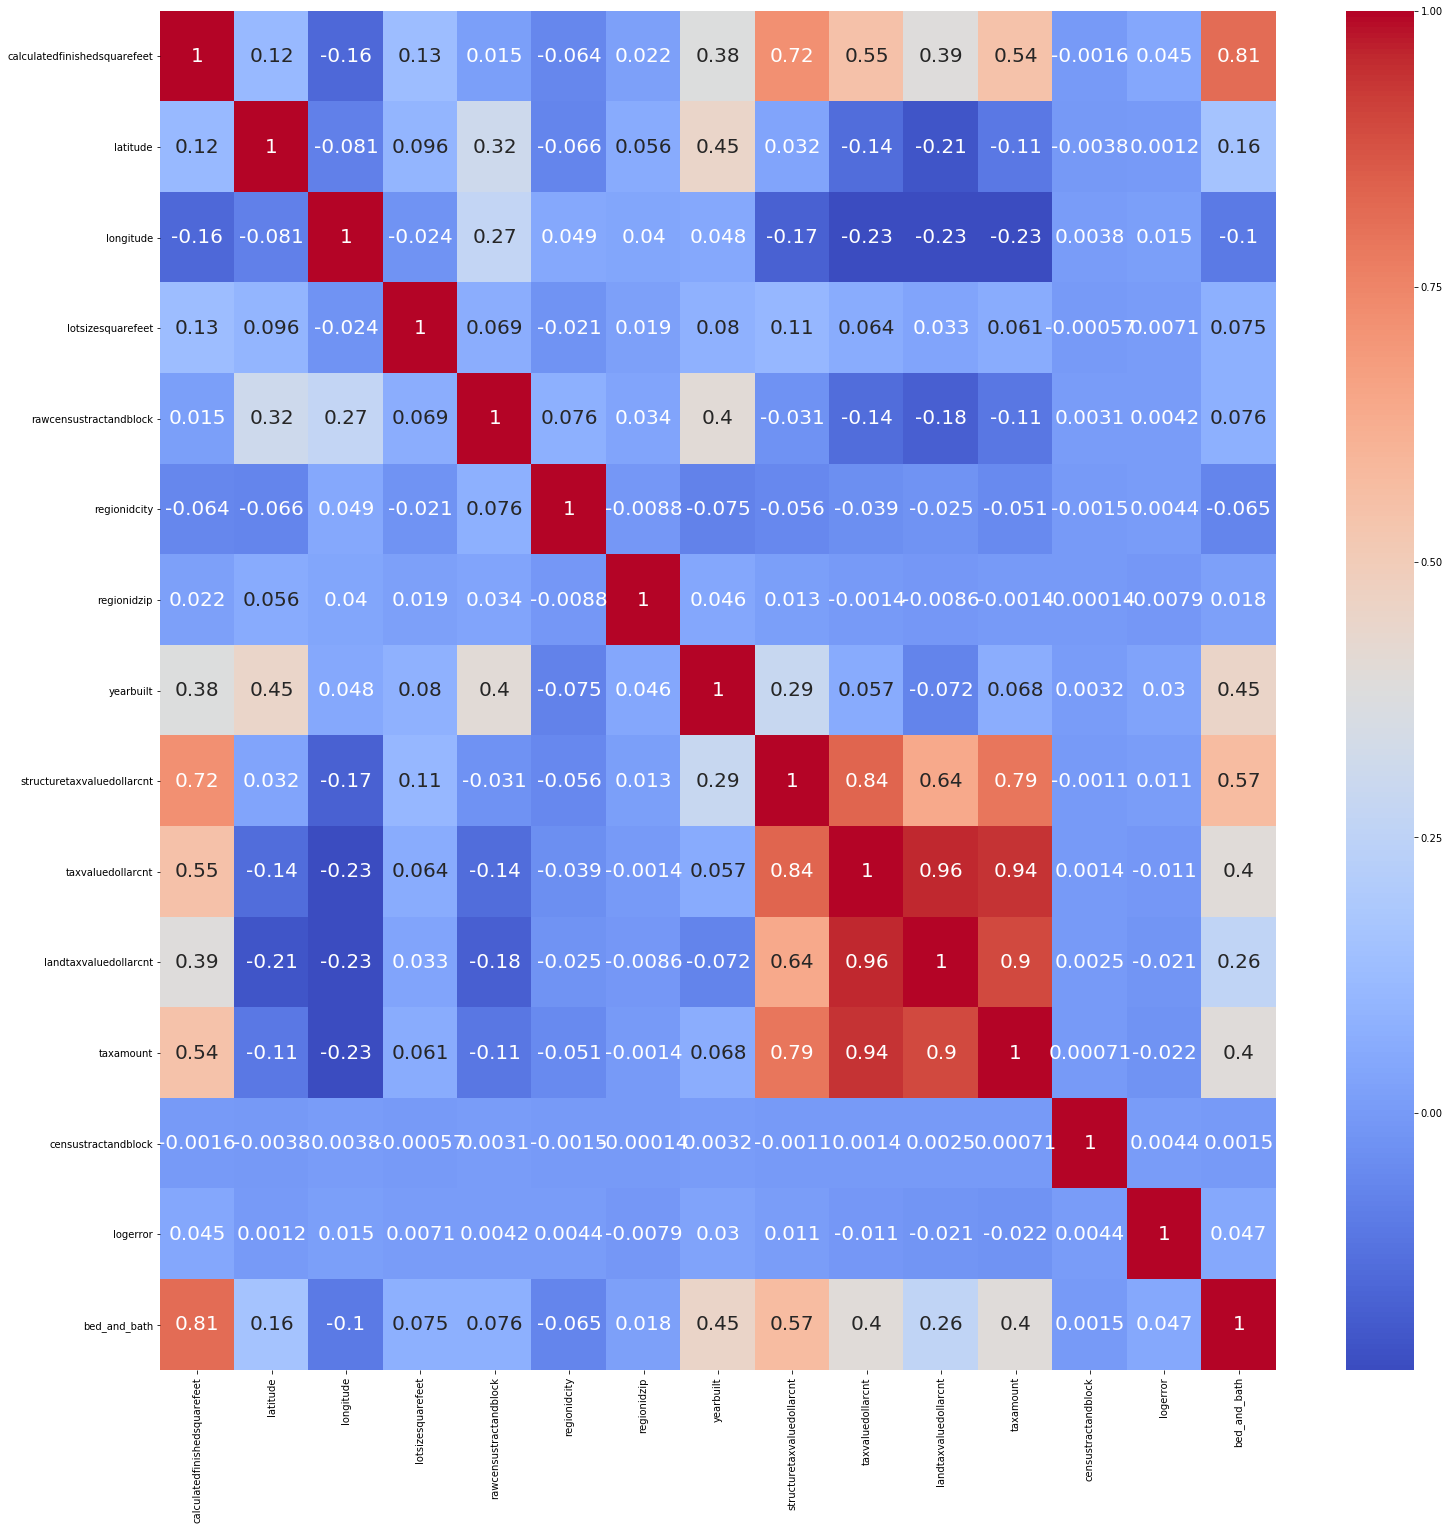

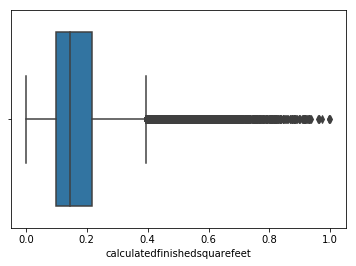

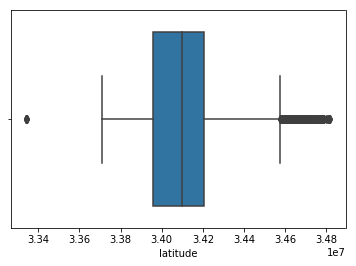

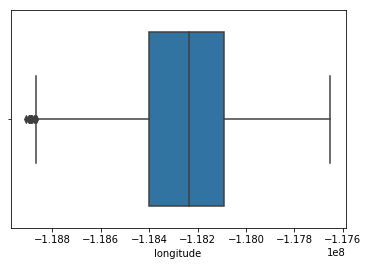

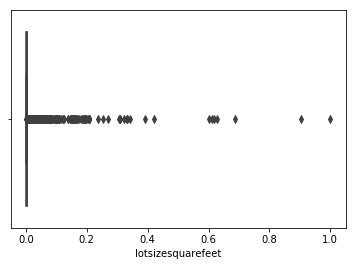

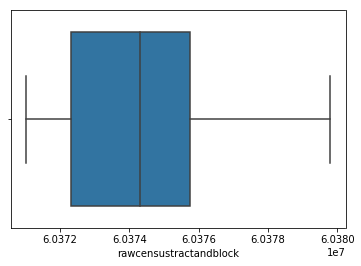

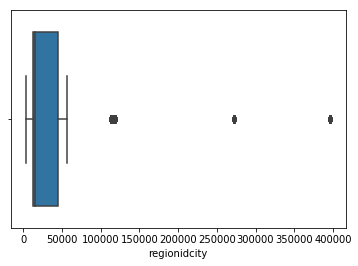

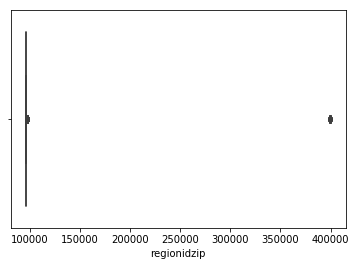

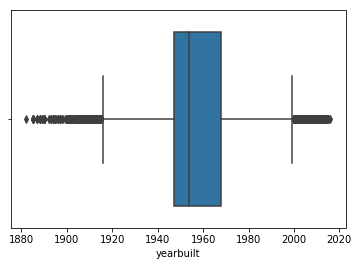

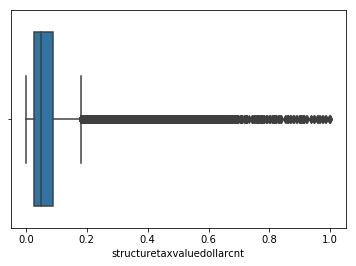

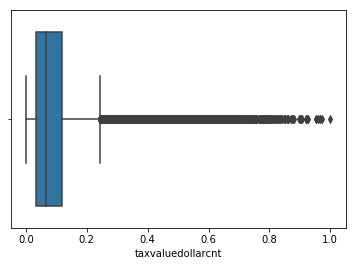

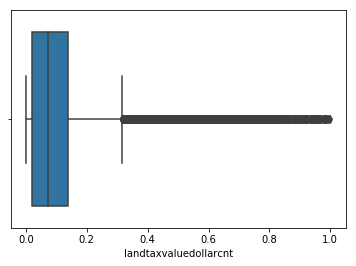

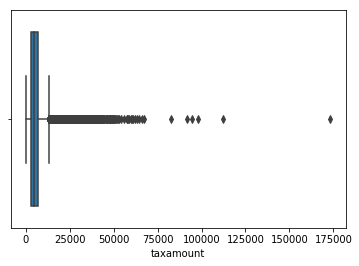

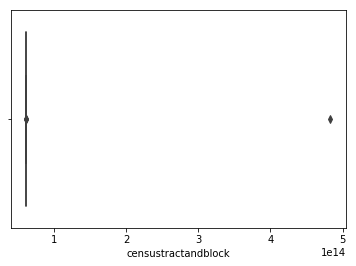

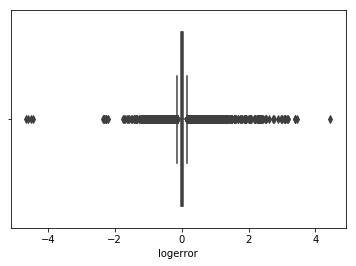

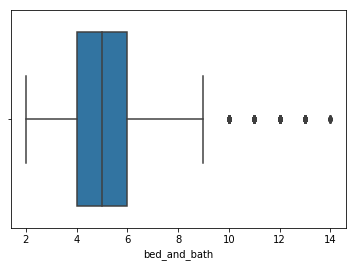

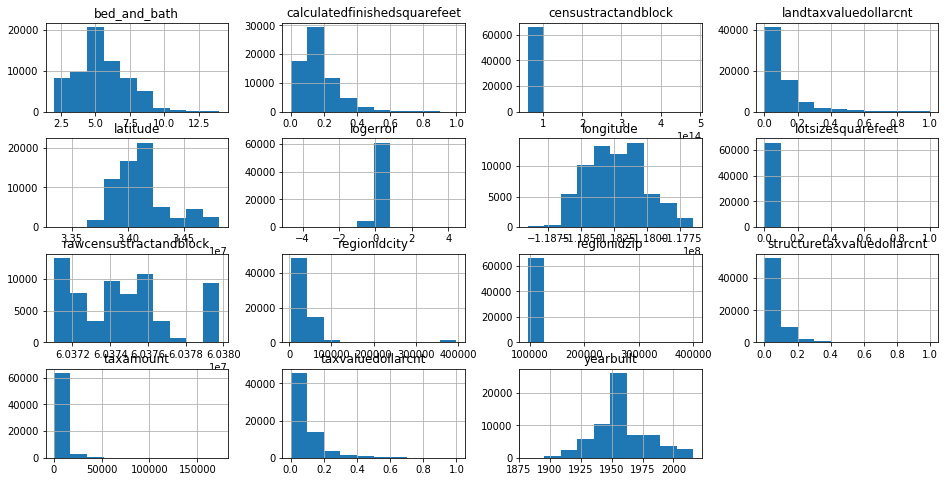

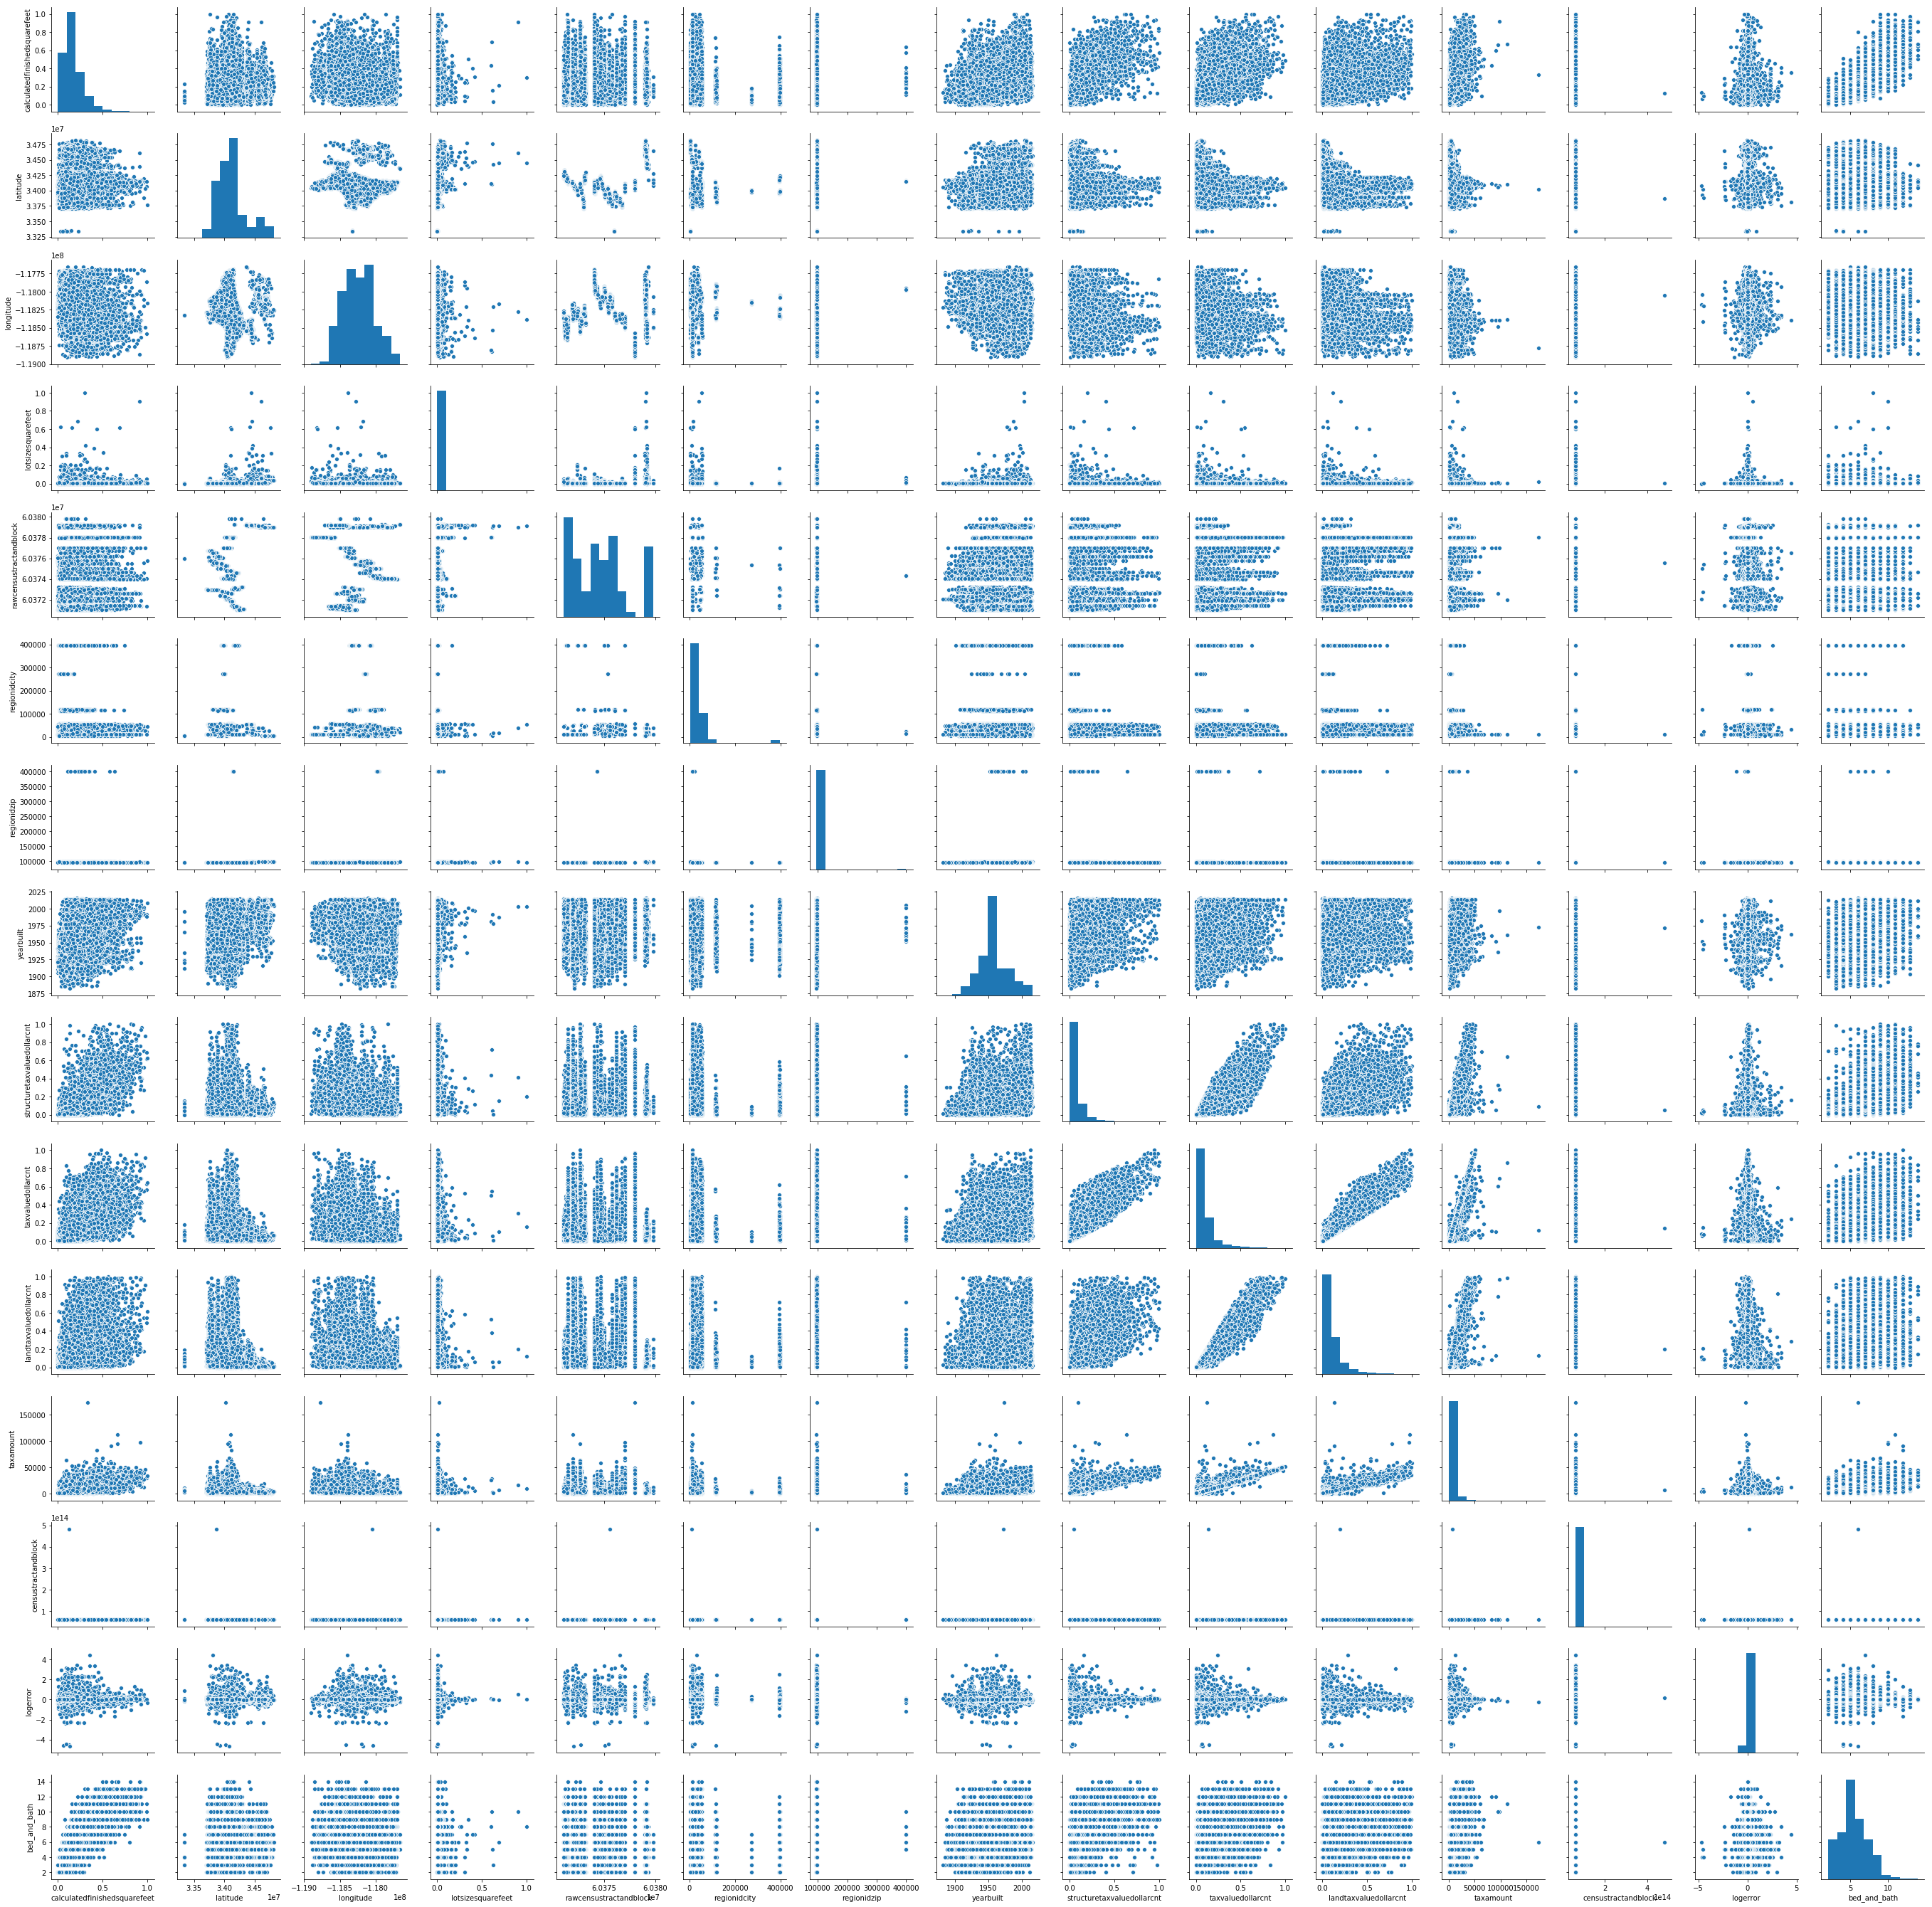

In [23]:
getplots(df, num_vars)

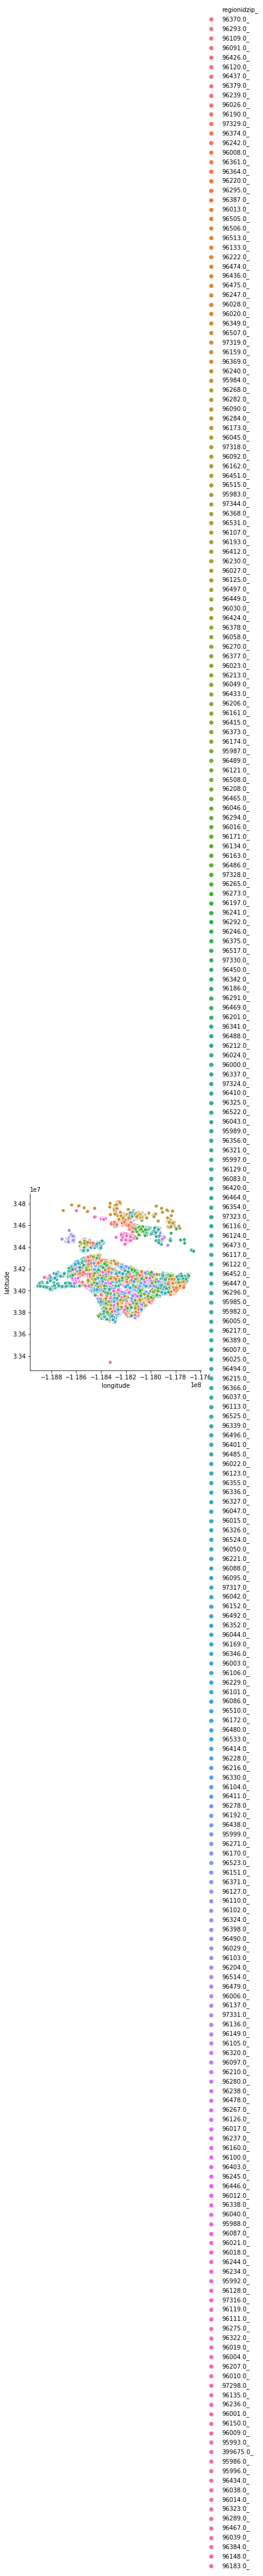

In [24]:
# relplot of latitude and longitude with zip codes for funsies
df['regionidzip_'] = df.regionidzip.astype('str') + '_'
df['regionidzip_'].head()
sns.relplot(x='longitude',y='latitude', hue='regionidzip_', data = df)

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


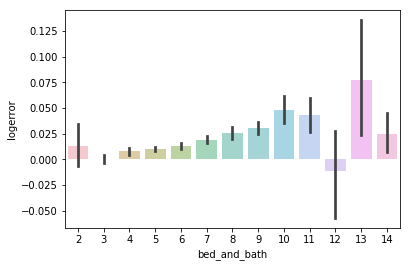

In [25]:
#quick barplot.  need to fix this to visualize more categorical variables.
cat_vars
sns.barplot('bed_and_bath', 'logerror', data=df, alpha=.5)
# _, ax = plt.subplots(nrows=1, ncols=8, figsize=(16,5))

# error_rate = df.logerror.mean()

# for i, feature in enumerate(features):
#     sns.barplot(feature, 'logerror', data=df, ax=ax[i], alpha=.5)

In [26]:
num_vars

['calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidcity',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror',
 'bed_and_bath']

In [27]:
# sns.barplot('regionidzip_', 'logerror', data=df, ax=ax[i], alpha=.5)

In [28]:
# sns.swarmplot(x="bed_and_bath", y="logerror", data=df, hue='regionidzip_')

In [29]:
# # hey here's a t_test
# stats.ttest_ind(df[df_mall.age < 30].spending_score.dropna(),
#                df[df_mall.age > 40].spending_score.dropna())

### First clustering attempt:

In [42]:
#only log error:
X = df[['logerror']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

Text(0.5, 1.0, 'The elbow method for logerror only')

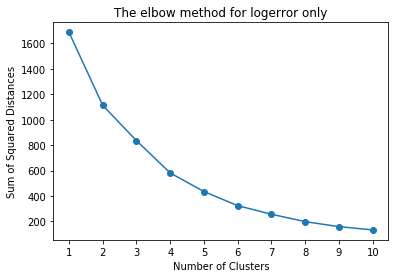

In [44]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method for logerror only')

#### It looks like 4 clusters is a good standard to use with this elbow model.  We will append the results of a 4 cluster model to our dataframe.

In [45]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
df['cluster_target'] = kmeans.predict(X)

In [46]:
df['cluster_target'].head()

0    0
1    0
2    3
3    0
4    1
Name: cluster_target, dtype: int32

### Let's test the significance of this clustering:

In [48]:
#if we bin everythging by clusters, our null hypothesis would be that 
# there is a roughly 25% distribution of entries across these clusters.
# Let's see the value counts in each of these clusters.
df.cluster_target.value_counts()

0    59779
1     3873
3     2242
2      164
Name: cluster_target, dtype: int64

### These numbers don't exactly look distributed evenly.  
### Let's run a chi^2 test for significance.

In [54]:
# first bin the logerrors so that they match our clusters: 
df['logerror_bin'] = pd.qcut(df.logerror, 4, labels=False)


tbl = pd.crosstab(df['cluster_target'], df['logerror_bin'])
tbl

logerror_bin        0      1      2      3
cluster_target                            
0               14443  16565  16293  12478
1                   0      0      0   3873
2                   0      0      0    164
3                2242      0      0      0

In [62]:
stat, p, dof, expected = stats.chi2_contingency(tbl)

In [61]:
print('p-statistic of logerror bins vs logerror clusters: {}'.format(p))

p-statistic of logerror bins vs logerror clusters: 0.0


In [63]:
#investigate again utilizing the absolute value of the log error this time
df['logerror_abs'] = df.logerror.abs()
df['logerror_abs_bin'] = pd.qcut(df.logerror_abs, 4, labels=False)

tbl = pd.crosstab(df['cluster_target'], df['logerror_abs_bin'])
tbl


logerror_abs_bin      0      1      2      3
cluster_target                              
0                 16515  16607  16421  10236
1                     0      0      0   3873
2                     0      0      0    164
3                     0      0      0   2242

In [72]:
#
stat, p, dof, expected = stats.chi2_contingency(tbl)
print('p-statistic of logerror bins vs logerror clusters: {}'.format(p))

for i in range(0,3):
    print(stats.ttest_ind(df[df.cluster_target == i].logerror,
                    df[df.cluster_target == (i+1)].logerror))

p-statistic of logerror bins vs logerror clusters: 0.0
Ttest_indResult(statistic=-275.6453678404411, pvalue=0.0)
Ttest_indResult(statistic=-81.61796844716594, pvalue=0.0)
Ttest_indResult(statistic=72.93366464729938, pvalue=0.0)


### still reading as zero, which makes a lot of sense considering we are comparing logerror to clusters based only upon logerror.

Let's try a new clustering based on latitude, longitude and

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


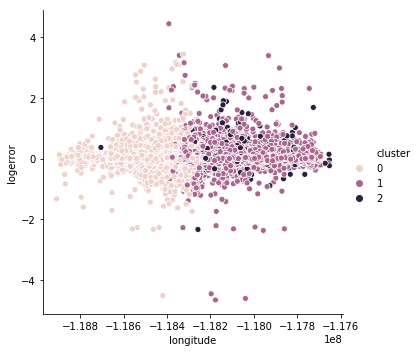

In [35]:
X = df[['longitude', 'latitude', 'logerror']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
X['cluster'] = kmeans.predict(X)

sns.relplot(data=X, x='longitude', y='logerror', hue='cluster')
 

In [36]:
X = df[['longitude', 'latitude', 'logerror']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

Text(0.5, 1.0, 'The elbow method')

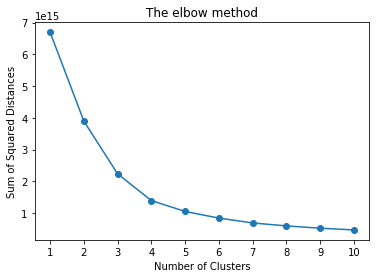

In [37]:
plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method')

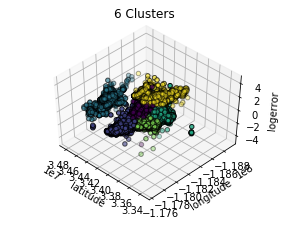

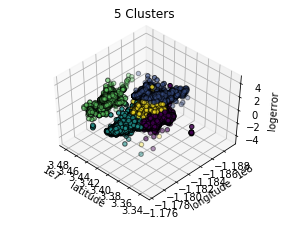

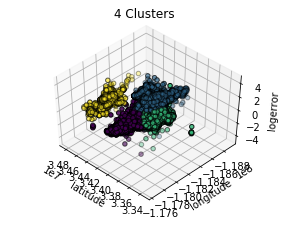

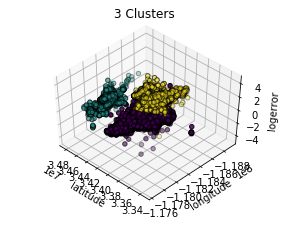

In [41]:
# visual comparison of Kmeans models using longitude/latitude and 

from mpl_toolkits.mplot3d import Axes3D


estimators = [('6 Clusters', KMeans(n_clusters=6)),
              ('5 Clusters', KMeans(n_clusters=5)),
              ('4 Clusters', KMeans(n_clusters=4)), 
             ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the model
    kmeans.fit(X)

    labels = kmeans.labels_

#     # setup the 3d plot
    fignum = i + 1
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#     # plot the points
    ax.scatter(X.latitude, X.longitude, X.logerror,
               c=labels.astype(np.float), edgecolor='k')

#     ax.w_xaxis.set_ticklabels([])
#     ax.w_yaxis.set_ticklabels([])
#     ax.w_zaxis.set_ticklabels([])

    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')
    ax.set_zlabel('logerror')

    ax.set_title(title)
    ax.dist = 12

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


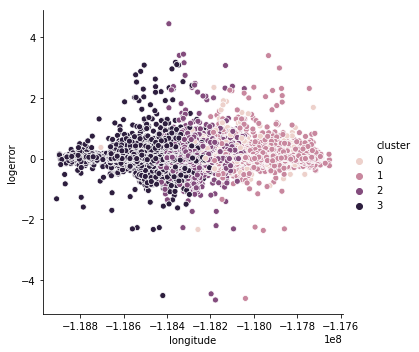

In [38]:
X = df[['longitude', 'latitude', 'logerror']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
X['cluster'] = kmeans.predict(X)

sns.relplot(data=X, x='longitude', y='logerror', hue='cluster')
 

Text(0.5, 1.0, 'The elbow method')

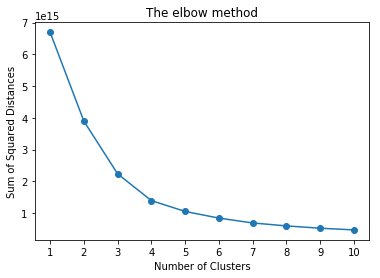

In [75]:
# clustering based strictly on location: 
X = df[['longitude', 'latitude']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method')

In [77]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
df['cluster_target_loc'] = kmeans.predict(X)

In [80]:
#add a new column for locational clusters
df['logerror_abs'] = df.logerror.abs()
df['logerror_abs_bin'] = pd.qcut(df.logerror_abs, 4, labels=False)

tbl = pd.crosstab(df['cluster_target_loc'], df['logerror_abs_bin'])
print(tbl)
stat, p, dof, expected = stats.chi2_contingency(tbl)
print('p-statistic of logerror bins vs location clusters: {}'.format(p))

logerror_abs_bin       0     1     2     3
cluster_target_loc                        
0                   5265  5552  5820  6125
1                   2115  1897  1585  1540
2                   4910  4938  4945  5068
3                   4225  4220  4071  3782
p-statistic of logerror bins vs location clusters: 2.466280524090669e-44


In [81]:
# We have a pretty low p-value here,
# we can reject the null hypothesis that these are proportionally distributed.

In [82]:
df0 = df[df.cluster_target_loc == 0]
df1 = df[df.cluster_target_loc == 1]
df2 = df[df.cluster_target_loc == 2]
df3 = df[df.cluster_target_loc == 3]

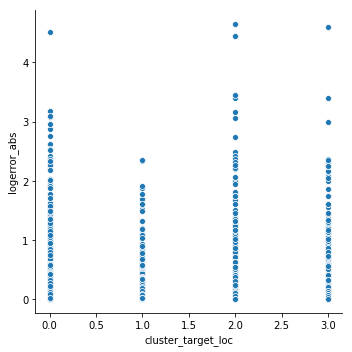

In [112]:
sns.relplot(x='cluster_target_loc', y='logerror_abs', data=df)

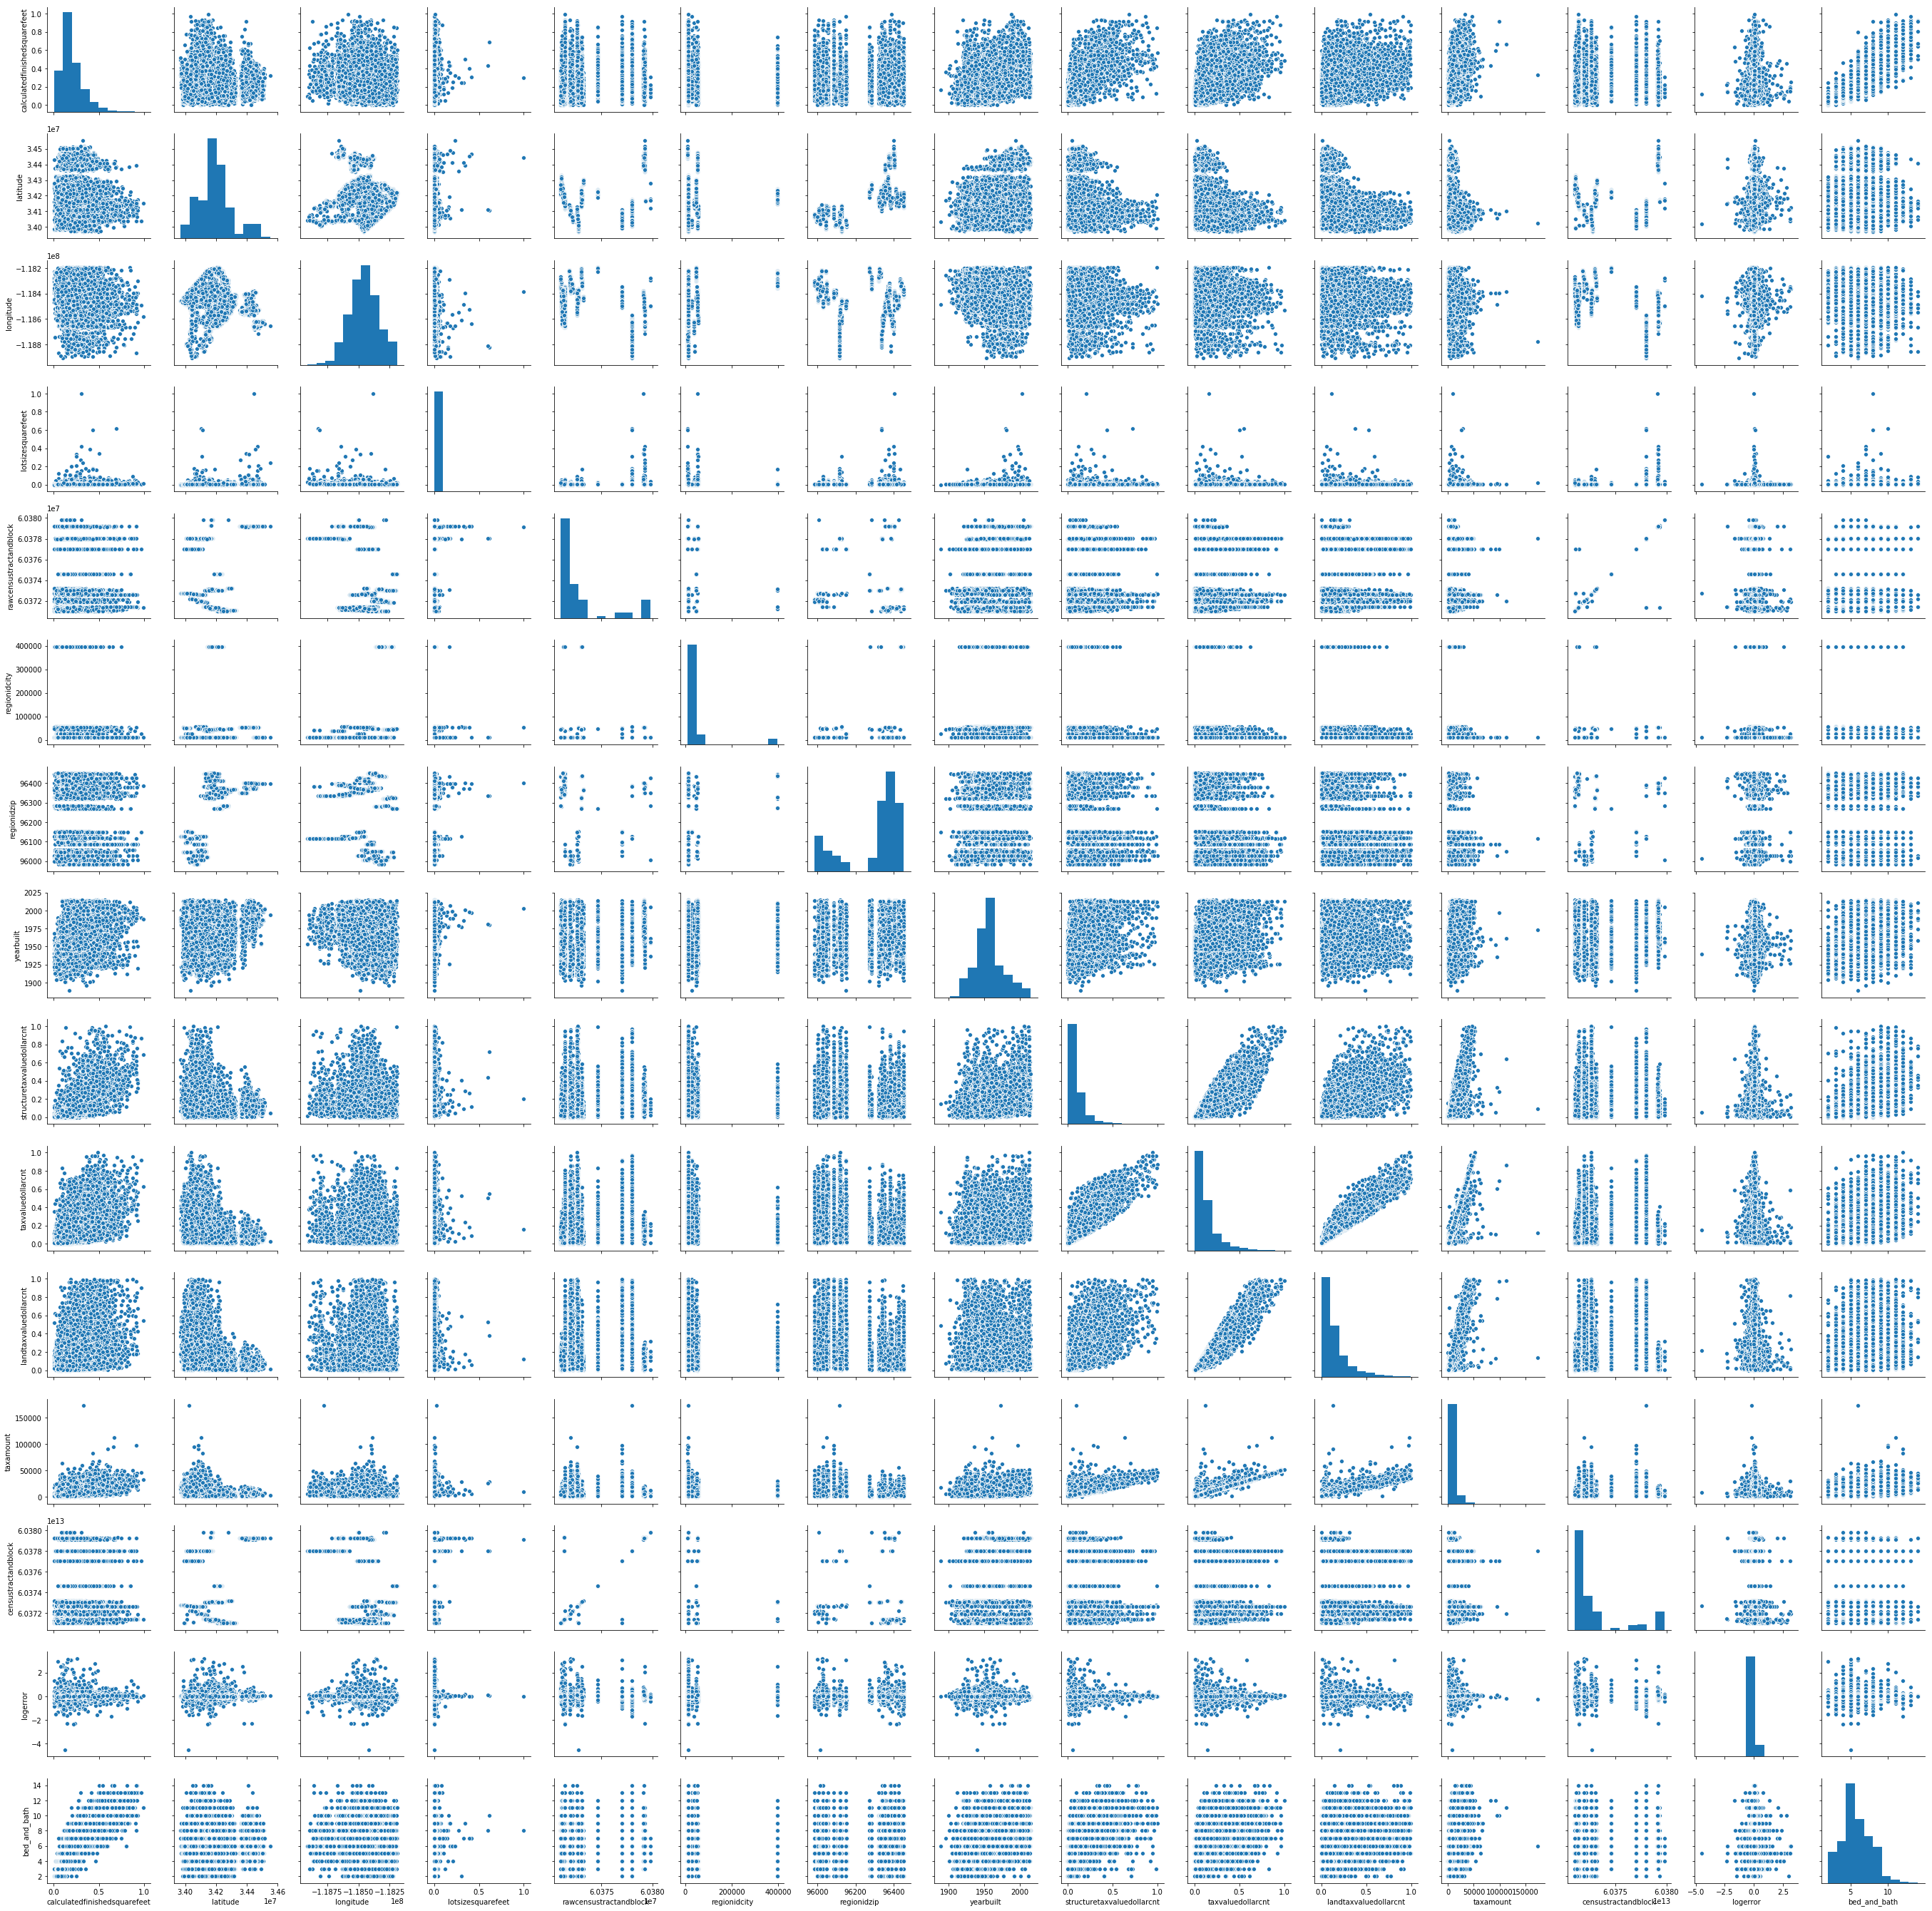

In [83]:
sns.pairplot(df0[num_vars])

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


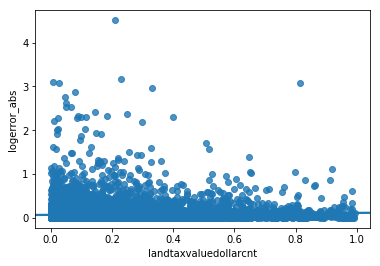

In [85]:
sns.regplot(x='landtaxvaluedollarcnt', y='logerror_abs', data=df0)

In [88]:
df_dumclusts = pd.get_dummies(df['cluster_target_loc'])

df_new = pd.concat([df, df_dumclusts], axis=1)

In [90]:
df_new.head()

id  parcelid  buildingqualitytypeid  calculatedfinishedsquarefeet  \
0  2931667  11016594                    4.0                      0.158183   
1  2444575  12098116                    4.0                      0.229392   
2  2843942  11509835                    1.0                      0.342953   
3  1628001  12286022                    7.0                      0.106480   
4   715639  10854446                    7.0                      0.122512   

     latitude    longitude  lotsizesquarefeet propertycountylandusecode  \
0  34280990.0 -118488536.0           0.002352                      0100   
1  34136312.0 -118175032.0           0.003727                      0100   
2  33870089.0 -118402768.0           0.000649                      0100   
3  33899475.0 -118212720.0           0.002051                      0100   
4  34164671.0 -118477995.0           0.002617                      0100   

   rawcensustractandblock  regionidcity ...  regionidzip_  cluster_target  \
0            6.037107e+07       12447.0 ...      96370.0_               0   
1            6.037464e+07       47019.0 ...      96293.0_               0   
2            6.037621e+07       29712.0 ...      96109.0_               3   
3            6.037542e+07       24174.0 ...      96091.0_               0   
4            6.037141e+07       12447.0 ...      96426.0_               1   

   logerror_bin  logerror_abs  logerror_abs_bin  cluster_target_loc  0  1  2  \
0             2        0.0276                 1                   0  1  0  0   
1             1        0.0040                 0                   3  0  0  0   
2             0        0.2705                 3                   2  0  0  1   
3             3        0.0440                 2                   2  0  0  1   
4             3        0.3825                 3                   0  1  0  0   

   3  
0  0  
1  1  
2  0  
3  0  
4  0  

[5 rows x 31 columns]

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree

from scipy.stats import pearsonr


In [99]:
X = df_new[[0, 1, 2, 3]]
y = df_new[['logerror_abs']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [102]:
[[column, pearsonr(train[column], train.logerror_abs)] for column in X_train] 


[[0, (0.019335772825549657, 8.77824835385255e-06)],
 [1, (-0.01871346759960615, 1.691295524913776e-05)],
 [2, (0.012726877824299274, 0.0034364157028940645)],
 [3, (-0.02133490361539092, 9.344405622912819e-07)]]

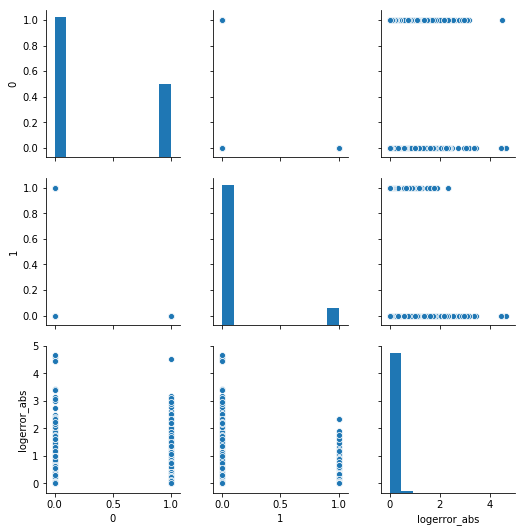

In [110]:
sns.pairplot(df_new[[0,1,'logerror_abs']])

In [118]:
#attempt to make a linear model based solely on cluster 1 as a feature,
# as it seems to have the most correlation. (still poor)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

lm1 = LinearRegression()
lm1.fit(X_train[[1]], y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_
y_pred_lm1 = lm1.predict(X_train[[1]])
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
r2_lm1 = r2_score(y_train, y_pred_lm1)
r2_lm1


0.00035019386960144505

Text(0.5, 1.0, 'The elbow method')

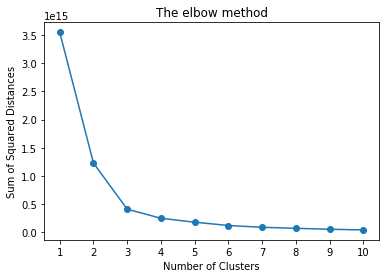

In [119]:
# clustering based on location zip code and latitude: 
X = df[['regionidzip', 'latitude']]

intertias = []
for numclusters in range(1, 11):
    kmeans = KMeans(n_clusters=numclusters)
    kmeans.fit(X)
    intertias.append(kmeans.inertia_)
    
kmeans_perf = pd.DataFrame(list(zip(range(1, 11), intertias)), columns=['n_clusters', 'ssd'])

plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

plt.xticks(range(1, 11))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('The elbow method')